## Multilevel Hierarchical Bayesian Model of Parasite Positivity by Location

Between 2014 and 2015 we resulted about 130,000 parasitology samples. About 115,000 of the samples were from the US, while the other 15,000 were from other countries. One way to estimate the positivity of our samples is to pool them all together and calculate an overall positivity. We’ve know this to be about 10.7% for a while now.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import pymc3 as pm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [ ]:
#Import data, do a little cleaning. 
demo = pd.read_excel("demo_cleaned_fully_09_2016.xlsx")
demo.Result = demo.Result.str.upper()
demo["positive_binary"] = 0
demo.loc[~(demo.Result == "NO OVA OR PARASITES SEEN"), "positive_binary"] = 1
demo.Result = demo.Result.str.title()
demo = demo[~(demo.Result == "Cancel")].reset_index(drop=True)
demo.loc[demo.local=="VIRGIN ISLANDS", "local"] = "VI"
demo = demo.dropna().reset_index(drop=True)
demo = demo.rename(columns={"local":"location"})
demo.loc[demo.location.str.len() > 2, 'location'] = demo.loc[demo.location.str.len() > 2].location.str.title()

In [36]:
print("Overall intestinal protozoa positivity: {:.1f}%".format(demo.positive_binary.mean()*100))

Overall intestinal protozoa positivity: 10.7%


The other way is to go to the complete opposite extreme (fully unpooled) and calculate a positivity for each location. Here’s what that data look like for states in the US:

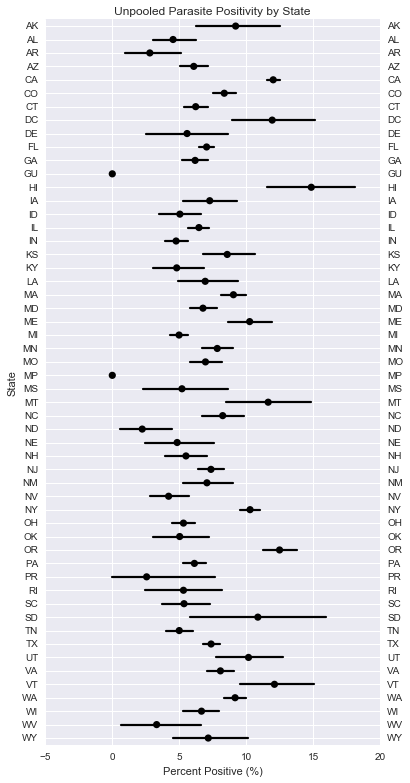

In [35]:
state = demo[demo.location.str.contains("^[A-Z][A-Z]$")]
state = state[~(state.location=="VI")].reset_index(drop=True)
state_list = state.location.dropna().unique()
state_list.sort()
state_list
sns.set_style("darkgrid")
sns.set_context("notebook")
plt.figure(figsize=(6, 13))
ax = sns.pointplot(x="positive_binary", y="State", data=state,\
              join=False, color="black",\
              order=[states for states in state_list], estimator=(lambda x: np.mean(x)*100),\
              scale=0.7)
#ax.set_xlim(left=0)
ax.set_xlabel("Percent Positive (%)")
#ax.xaxis.set_label_position("top")
plt.title("Unpooled Parasite Positivity by State")
ax.tick_params(labelbottom="on", labeltop="off", labelleft="on", labelright="on")
ax.yaxis.grid(True)

Hawaii (HI) above happens to have the highest midpoint estimation (just under 15%), but its uncertainty tails are pretty wide, making the likely value anywhere between about 12% and 18%. The uncertainty in the estimate is due to only resulting about 500 samples from HI. You can see the tails get even wider for places with less samples (e.g. SD – 154 samples), and very narrow for places with a lot of samples (e.g. CA – 20,000 samples). The problem with this approach is that it breaks down with places from which we’ve received only a few samples. For example, Guam (GU) and the Northern Mariana Islands (MP) both have estimates of zero. The few samples we received from those places all happened to be negative, but in reality are the positivities in these places really likely to be zero? No! 

You can see the situation gets even worse when we add in all of the locations from which we’ve received a sample:

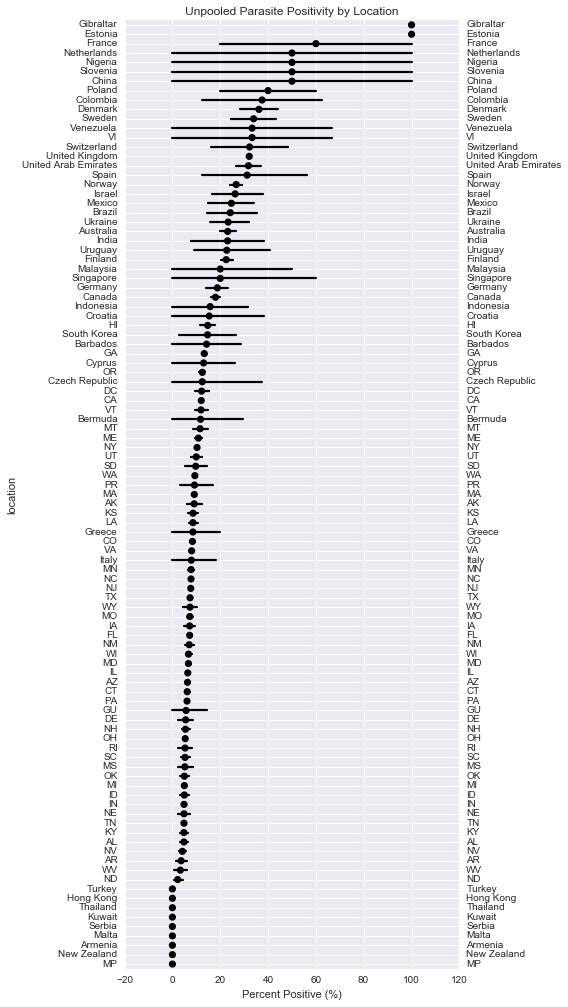

In [37]:
sns.set_style("darkgrid")
sns.set_context("notebook")
plt.figure(figsize=(6, 17))
ax = sns.pointplot(x="positive_binary", y="location", data=demo,\
              join=False, color="black",\
              estimator=(lambda x: np.mean(x)*100),\
              scale=0.7, order=[i for i in demo[['positive_binary', 'location']]\
              .groupby("location").mean().sort_values(by="positive_binary", ascending=False).index.values])
#ax.set_xlim(left=0)
ax.set_xlabel("Percent Positive (%)")
#ax.xaxis.set_label_position("top")
plt.title("Unpooled Parasite Positivity by Location")
ax.tick_params(labelbottom="on", labeltop="off", labelleft="on", labelright="on")
ax.yaxis.grid(True)
#ax.set_xlim([-5,105])

Just because the one sample we received from Gibraltar was positive, it’s unlikely that 100% of people submitting samples from Gibraltar have parasites. The same goes for the other high-variance, low-sample-number places that make up the head and tail of graph. If you had to guess the positivity of samples from Thailand, I bet you wouldn’t say 0%, which is what the unpooled estimate says. So what to do?

It turns out that one good approach to this is to build a probabilistic model that takes advantage of some of the underlying structure in the data. For example, the data naturally have a hierarchical structure. The states make up the United States, the United States makes up a region, the regions make up all of the samples that we've received. We can assume that states in the United States are likely to be similar to other states in the United States, and so they all share a hyper (group) positivity.

Building a model with this structure in mind, and then fitting the parameters given the data we’ve observed, is in essence a mixture between the two extreme approaches above (fully pooled and fully unpooled). When a state has only a few data points it will rely more heavily on the group parameters. When a state has a lot of data points it will overwhelm the group estimation (while at the same time contributing to it). Here’s what this kind of partially pooled model looks like for the states: 

In [88]:
#Encode state data numerically, create index that can be used by model.
le = LabelEncoder()
state["location_encoded"] = le.fit_transform(state.location)
state_names = state.location.unique()
state_idx = state.location_encoded.values
n_states = len(state.location.unique())

In [89]:
#Specify Bayesian model. 
with pm.Model() as model:
    #Weakly-informative prior that mean positivity is less than 50%.
    usa_group_mean = pm.Beta("usa_group_mean", 2, 5)
    usa_group_std = pm.HalfNormal("usa_group_std", 100)
    
    positivity_prior = pm.Beta("positivity_prior", mu=usa_group_mean, sd=usa_group_std, shape=n_states)
    parasite_positivity = pm.Bernoulli("parasite_positivity",\
                                       p=positivity_prior[state_idx],\
                                       observed=state.positive_binary)

Applied logodds-transform to usa_group_mean and added transformed usa_group_mean_logodds to model.
Applied log-transform to usa_group_std and added transformed usa_group_std_log to model.
Applied logodds-transform to positivity_prior and added transformed positivity_prior_logodds to model.


In [90]:
#Fit model with variational inference algorithm. 
with model:
    v_params = pm.variational.advi(n=50000)
    trace = pm.variational.sample_vp(v_params, draws=5000)

Iteration 0 [0%]: ELBO = -inf
Iteration 5000 [10%]: ELBO = -34695.95
Iteration 10000 [20%]: ELBO = -33227.78
Iteration 15000 [30%]: ELBO = -33148.6
Iteration 20000 [40%]: ELBO = -33104.24
Iteration 25000 [50%]: ELBO = -33112.3
Iteration 30000 [60%]: ELBO = -33118.52
Iteration 35000 [70%]: ELBO = -33101.29
Iteration 40000 [80%]: ELBO = -33094.28
Iteration 45000 [90%]: ELBO = -33109.04
Finished [100%]: ELBO = -33117.87


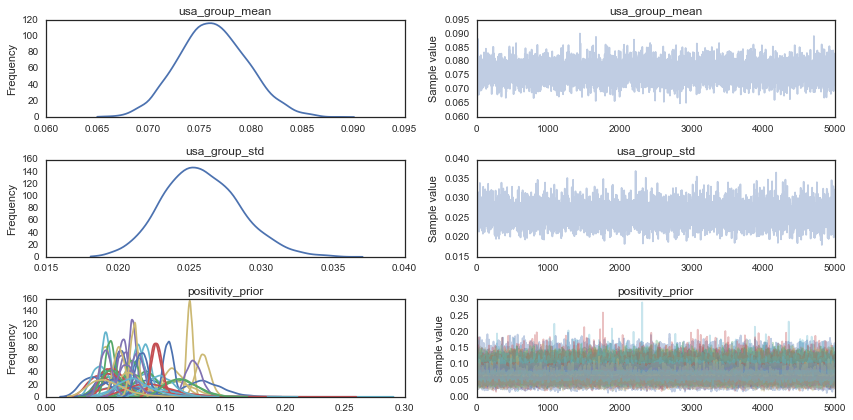

In [91]:
#Check posterior distributions/convergence. 
sns.set_style('white')
pm.traceplot(trace);

In [92]:
#Map results to state names. 
results = pm.df_summary(trace)
results = results[results.index.str.contains('positivity')].reset_index(drop=True)
results["location"] = results.reset_index().reset_index()['level_0'].map(lambda x: le.inverse_transform(x)).values
results["location_code"] = results.reset_index().reset_index().level_0.values
results["location_code_inverse"] = results.location_code.sort_values(ascending=False).values
results = results.sort_values(by="location_code_inverse")
results['mean'] = results['mean'] * 100
results['hpd_2.5'] = results['hpd_2.5'] * 100
results['hpd_97.5'] = results['hpd_97.5'] * 100
results['order'] = results.reset_index()['index']

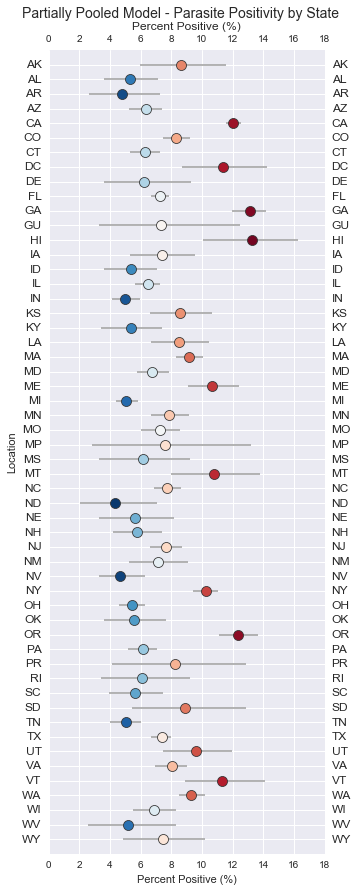

In [93]:
#Plot results.
sns.set_context("notebook")
sns.set_style("darkgrid")
#Chart code borrowed from Jonathan Sedar.
#https://github.com/jonsedar/pymc3_vs_pystan/blob/master/40_HierarchicalLinearRegression.ipynb
g = sns.FacetGrid(hue="mean", data=results, palette="RdBu_r", size=12, aspect=0.4)
g.map(plt.scatter, 'mean', 'order', marker="o", s=100, edgecolor="#333333", linewidth=0.8, zorder=10)
g.map(plt.hlines, 'order', 'hpd_2.5', 'hpd_97.5', color="#aaaaaa")
g.axes.flat[0].set_ylabel("Location")
g.axes.flat[0].set_xlabel("Percent Positive (%)")
g.axes.flat[0].set_ylim([-1, results["order"].max() + 1])
g.axes.flat[0].set_yticks(np.arange(results["order"].max() + 1))
g.axes.flat[0].set_yticklabels(results.location, size=12);
plt.gca().tick_params(labelbottom="on", labeltop="on", labelleft="on", labelright="on")
ax1 = plt.gca()
ax1.set_xlim(left=0)
ax2 = ax1.twiny()
ax2.set_zorder(1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("Percent Positive (%)", size=12)
ax1.set_zorder(ax2.get_zorder()+1)
plt.suptitle("Partially Pooled Model - Parasite Positivity by State", y=1.03, x=0.53, size=14);

States like CA with a lot of data haven’t moved, but places like GU and MP that used to have estimates of zero are pulled up towards the group mean. They still have a high uncertainty (as they should for only a few data points). If this seems a little hinky to you, remember that this is only a model of how the world might work, and I hope you agree that that the estimates of GU and MP for example are now much more likely and reasonable. It’s all built on the assumption that the states as a group are similar enough to share characteristics. 

We can extend this idea to the rest of the data. Since we have state-level data for places inside of the US and country-level data everywhere else, the next model assumes two groups. The first group is the United States, which contains all of the states (equivalent to countries elsewhere). The second group is anything outside of the US (naively bundled together), which contains all of the other countries. Since US samples have a mean positivity of about 8% and non-US samples have a mean positivity of about 25%, you can see a pretty clear separation between the US and non-US groups:

In [47]:
#Process repeated as above.
demo["region"] = 0
demo.loc[demo.location.str.contains("^[A-Z][A-Z]$"), "region"] = "USA"
demo.loc[~(demo.location.str.contains("^[A-Z][A-Z]$")), "region"] = "NON-USA"
usa_nusa = demo[["positive_binary", "location", "region"]]

In [48]:
usa_nusa = usa_nusa.reset_index(drop=True)

location_le = LabelEncoder()
usa_nusa["location_encoded"] = location_le.fit_transform(usa_nusa.location)
location_names = usa_nusa.location.unique()
location_idx = usa_nusa.location_encoded.values
n_locations = len(usa_nusa.location.unique())

region_le = LabelEncoder()
usa_nusa["region_encoded"] = region_le.fit_transform(usa_nusa.region)
region_names = usa_nusa.region.unique()
region_idx = usa_nusa.region_encoded.values
n_regions = len(usa_nusa.region.unique())

location_region_map = (usa_nusa.groupby(["location_encoded", "region_encoded"])\
                       .size().reset_index()['region_encoded'].values)

In [55]:
with pm.Model() as multi_level_model:
    overall_mean = pm.Beta("overall_mean", 2, 5)
    overall_std = pm.HalfNormal("overall_std", 100)
    
    region_mean = pm.Beta("region_mean", mu=overall_mean, sd=overall_std, shape=n_regions)
    region_std = pm.HalfNormal("region_std", 100)
    
    location_mean = pm.Beta("location_mean", mu=region_mean[location_region_map], sd=region_std, shape=n_locations)
    
    observed_positivity = pm.Bernoulli("observed_positivity", p=location_mean[location_idx], observed=usa_nusa.positive_binary)

Applied logodds-transform to overall_mean and added transformed overall_mean_logodds to model.
Applied log-transform to overall_std and added transformed overall_std_log to model.
Applied logodds-transform to region_mean and added transformed region_mean_logodds to model.
Applied log-transform to region_std and added transformed region_std_log to model.
Applied logodds-transform to location_mean and added transformed location_mean_logodds to model.


In [52]:
with multi_level_model:
    v_params = pm.variational.advi(n=50000)
    trace = pm.variational.sample_vp(v_params, draws=5000)

Iteration 0 [0%]: ELBO = -63827.07
Iteration 5000 [10%]: ELBO = -43092.98
Iteration 10000 [20%]: ELBO = -41556.65
Iteration 15000 [30%]: ELBO = -41485.53
Iteration 20000 [40%]: ELBO = -41449.07
Iteration 25000 [50%]: ELBO = -41466.45
Iteration 30000 [60%]: ELBO = -41468.14
Iteration 35000 [70%]: ELBO = -41438.48
Iteration 40000 [80%]: ELBO = -41431.27
Iteration 45000 [90%]: ELBO = -41441.73
Finished [100%]: ELBO = -41464.13


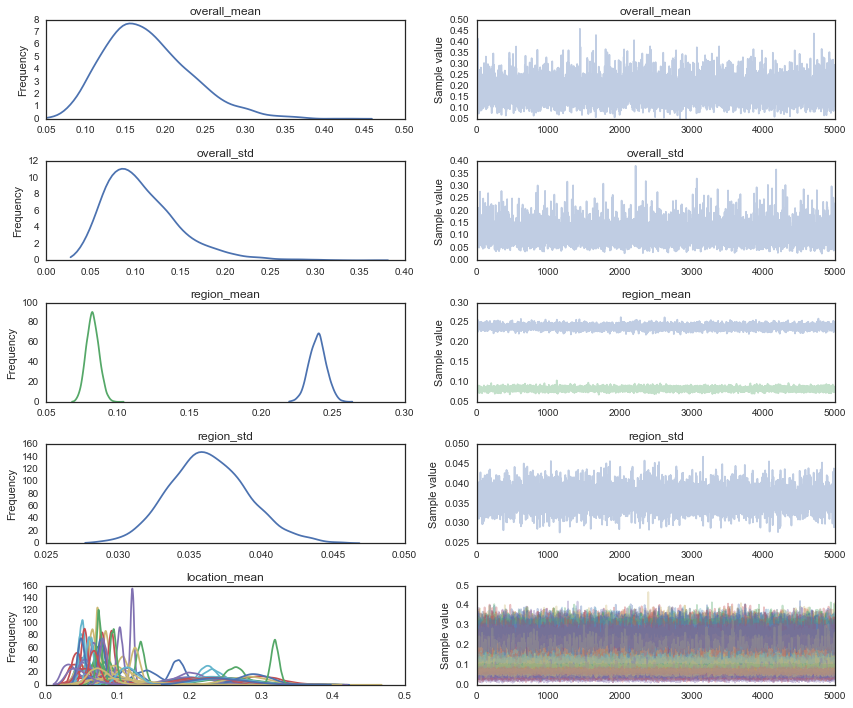

In [54]:
sns.set_style('white')
pm.traceplot(trace);

In [56]:
results = pm.df_summary(trace)
results = results[~results.index.isin(["overall_mean", "overall_std",\
                                       "region_std", "region_mean__0", "region_mean__0",\
                                       "region_mean__1"])].reset_index(drop=True)
results["location"] = results.reset_index().reset_index()['level_0'].map(lambda x: location_le.inverse_transform(x)).values
results["location_code"] = results.reset_index().reset_index().level_0.values
results["location_code_inverse"] = results.location_code.sort_values(ascending=False).values
results = results.sort_values(by="location_code_inverse")
results['region'] = 0
results.loc[results.location.str.contains("^[A-Z][A-Z]$"), "region"] = 0
results.loc[~(results.location.str.contains("^[A-Z][A-Z]$")), "region"] = 1
results = results.sort_values(by=["region", "location_code_inverse"], ascending=[False, True]).reset_index(drop=True)
results['mean'] = results['mean'] * 100
results['hpd_2.5'] = results['hpd_2.5'] * 100
results['hpd_97.5'] = results['hpd_97.5'] * 100
results['order'] = results.reset_index()['index']
results.loc[(results.location.str.len() > 2), "location"] = results.loc[(results.location.str.len() > 2)].location.str.title()

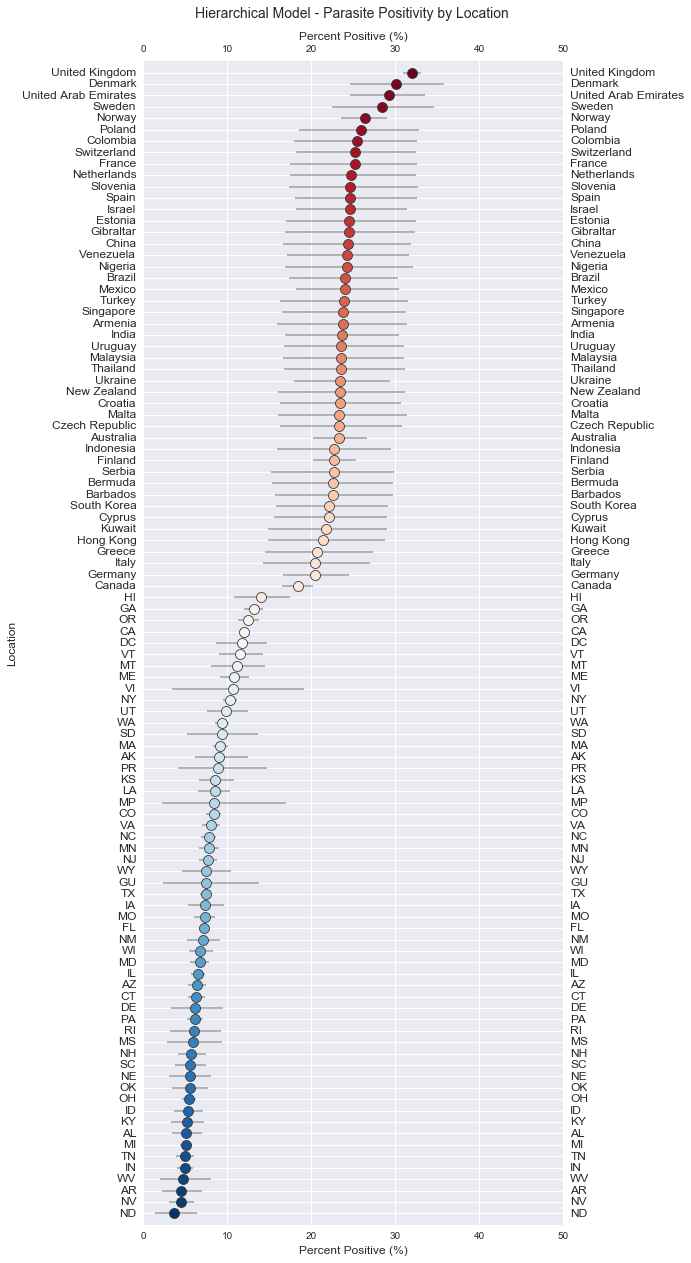

In [57]:
sns.set_context("notebook")
sns.set_style("darkgrid")
g = sns.FacetGrid(hue="mean", data=results.sort_values(by="mean").reset_index().reset_index(),\
                  palette="RdBu_r", size=17, aspect=0.4)
g.map(plt.scatter, 'mean', "level_0", marker="o", s=100, edgecolor="#333333", linewidth=0.8, zorder=10)
g.map(plt.hlines, 'level_0', 'hpd_2.5', 'hpd_97.5', color="#aaaaaa")
g.axes.flat[0].set_ylabel("Location", size=12)
g.axes.flat[0].set_xlabel("Percent Positive (%)", size=12)
g.axes.flat[0].set_ylim([-1, results["order"].max() + 1])
g.axes.flat[0].set_yticks(np.arange(results["order"].max() + 1))
g.axes.flat[0].set_yticklabels(results.sort_values(by="mean").reset_index().reset_index().location, size=12);
plt.gca().tick_params(labelbottom="on", labeltop="on", labelleft="on", labelright="on")
ax1 = plt.gca()
ax1.set_xlim([0,50])
ax2 = ax1.twiny()
ax2.set_zorder(1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("Percent Positive (%)", size=12)
ax1.set_zorder(ax2.get_zorder()+1)
plt.suptitle("Hierarchical Model - Parasite Positivity by Location", y=1.03, x=0.53, size=14);

This model is pretty, but the UK, with a lot of data and a mean positivity of about 30%, heavily skews the non-US group. So grouping everything together as either US or non-US might not be the best assumption. The model also assumes a shared variance between the group, which is why the error bars are so regularized in the non-US group. This is probably not the best assumption to make either.

Improving upon the model, we can separate all of the data into logical regions. Here I’ve chosen the following regions: US, North America (not USA), South America (including Mexico), Europe, Middle East, Asia, Africa, Australia/New Zealand. The assumption here is that samples from European countries are more likely to be similar to other European samples, etc. I’ve also let each group draw from its own variance distribution, instead of sharing one. Here’s what this new and improved model looks like:

In [59]:
#Encode Regions: USA, North America (not USA), South America (includes Mexico), Europe, Middle East, Africa, Asia, Australia
demo["region"] = 0
region_list = ["USA", "North America (not USA)", "South America (includes Mexico)",\
               "Europe", "Middle East", "Africa", "Asia", "Australia"]
multi_reg_le = LabelEncoder()
region_list_transformed = multi_reg_le.fit_transform(region_list)

In [ ]:
#Assign location to region.
for i in demo.location.value_counts().index.values:
    if len(i) > 2:
        for z in range(len(region_list)):
            print(z, multi_reg_le.inverse_transform(z))
        print(i)
        reg_code = input("Enter region: ")
        demo.loc[demo.location==i, "region"] = reg_code
    else:
        demo.loc[demo.location==i, "region"] = 7

In [64]:
demo.region = demo.region.map(lambda x: multi_reg_le.inverse_transform(int(x)))
complex_regions = demo.reset_index(drop=True)

location_le = LabelEncoder()
complex_regions["location_encoded"] = location_le.fit_transform(complex_regions.location)
location_names = complex_regions.location.unique()
location_idx = complex_regions.location_encoded.values
n_locations = len(complex_regions.location.unique())

region_le = LabelEncoder()
complex_regions["region_encoded"] = region_le.fit_transform(complex_regions.region)
region_names = complex_regions.region.unique()
region_idx = complex_regions.region_encoded.values
n_regions = len(complex_regions.region.unique())

location_region_map = (complex_regions.groupby(["location_encoded", "region_encoded"])\
                       .size().reset_index()['region_encoded'].values)

In [66]:
with pm.Model() as multi_level_model:
    overall_mean = pm.Beta("overall_mean", 2, 5)
    overall_std = pm.HalfNormal("overall_std", 100)
    
    region_mean = pm.Beta("region_mean", mu=overall_mean, sd=overall_std, shape=n_regions)
    region_std = pm.HalfNormal("region_std", 100, shape=n_regions)
    
    location_mean = pm.Beta("location_mean", mu=region_mean[location_region_map],\
                            sd=region_std[location_region_map], shape=n_locations)
    
    observed_positivity = pm.Bernoulli("observed_positivity", p=location_mean[location_idx],\
                                       observed=complex_regions.positive_binary)

Applied logodds-transform to overall_mean and added transformed overall_mean_logodds to model.
Applied log-transform to overall_std and added transformed overall_std_log to model.
Applied logodds-transform to region_mean and added transformed region_mean_logodds to model.
Applied log-transform to region_std and added transformed region_std_log to model.
Applied logodds-transform to location_mean and added transformed location_mean_logodds to model.


In [67]:
with multi_level_model:
    v_params = pm.variational.advi(n=50000)
    trace = pm.variational.sample_vp(v_params, draws=5000)

Iteration 0 [0%]: ELBO = -75948.52
Iteration 5000 [10%]: ELBO = -42934.93
Iteration 10000 [20%]: ELBO = -41569.73
Iteration 15000 [30%]: ELBO = -41487.33
Iteration 20000 [40%]: ELBO = -41455.17
Iteration 25000 [50%]: ELBO = -41472.24
Iteration 30000 [60%]: ELBO = -41472.2
Iteration 35000 [70%]: ELBO = -41444.24
Iteration 40000 [80%]: ELBO = -41435.97
Iteration 45000 [90%]: ELBO = -41441.37
Finished [100%]: ELBO = -41462.88


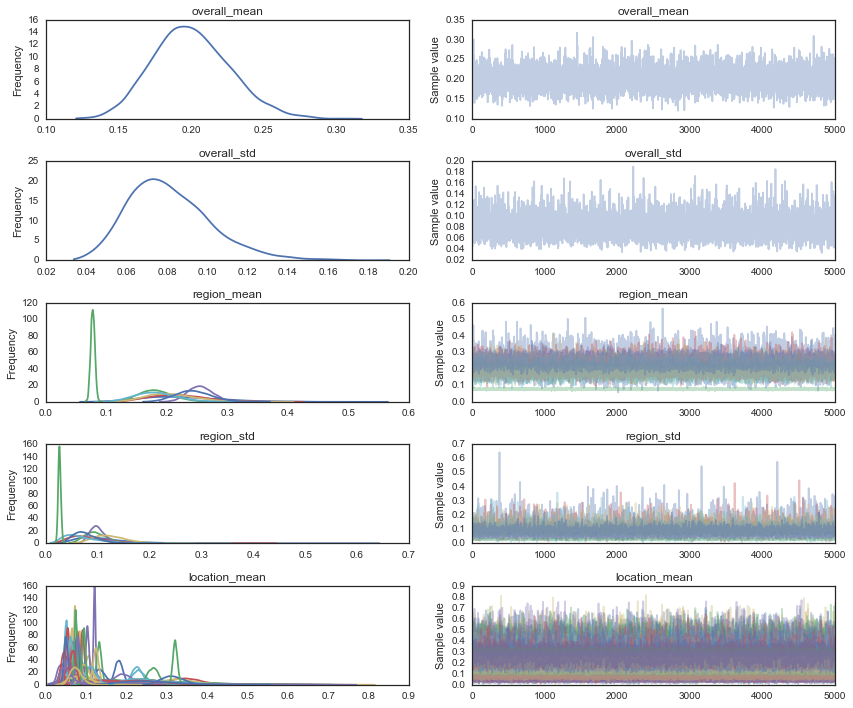

In [69]:
sns.set_style('white')
pm.traceplot(trace);

In [70]:
results = pm.df_summary(trace)
results = results[results.index.str.contains("location")]
results["location"] = results.reset_index().reset_index()['level_0'].map(lambda x: location_le.inverse_transform(x)).values
results["location_code"] = results.reset_index().reset_index().level_0.values
results["location_code_inverse"] = results.location_code.sort_values(ascending=False).values
results = results.sort_values(by="location_code_inverse")
results['region'] = 0
results.loc[results.location.str.contains("^[A-Z][A-Z]$"), "region"] = 0
results.loc[~(results.location.str.contains("^[A-Z][A-Z]$")), "region"] = 1
results = results.sort_values(by=["region", "location_code_inverse"], ascending=[False, True]).reset_index(drop=True)
results['mean'] = results['mean'] * 100
results['hpd_2.5'] = results['hpd_2.5'] * 100
results['hpd_97.5'] = results['hpd_97.5'] * 100
results['order'] = results.reset_index()['index']
results.loc[(results.location.str.len() > 2), "location"] = results.loc[(results.location.str.len() > 2)].location.str.title()

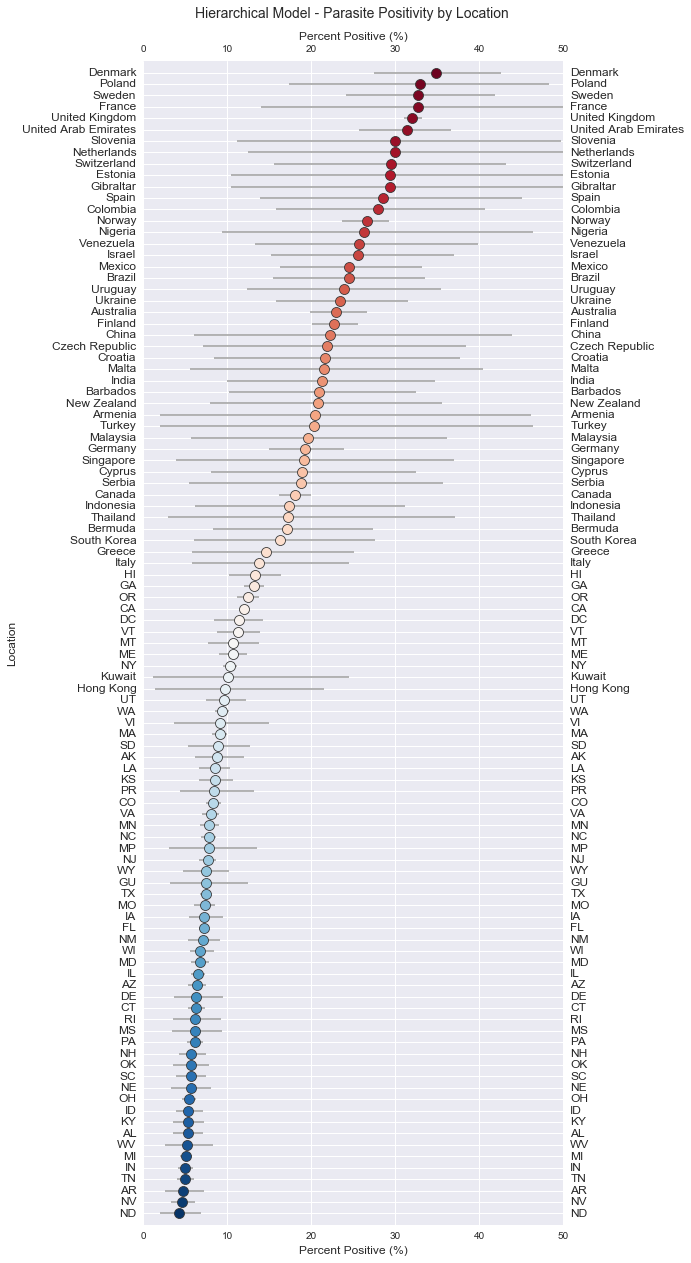

In [72]:
sns.set_context("notebook")
sns.set_style("darkgrid")
g = sns.FacetGrid(hue="mean", data=results.sort_values(by="mean").reset_index().reset_index(),\
                  palette="RdBu_r", size=17, aspect=0.4)
g.map(plt.scatter, 'mean', "level_0", marker="o", s=100, edgecolor="#333333", linewidth=0.8, zorder=10)
g.map(plt.hlines, 'level_0', 'hpd_2.5', 'hpd_97.5', color="#aaaaaa")
g.axes.flat[0].set_ylabel("Location", size=12)
g.axes.flat[0].set_xlabel("Percent Positive (%)", size=12)
g.axes.flat[0].set_ylim([-1, results["order"].max() + 1])
g.axes.flat[0].set_yticks(np.arange(results["order"].max() + 1))
g.axes.flat[0].set_yticklabels(results.sort_values(by="mean").reset_index().reset_index().location, size=12);
plt.gca().tick_params(labelbottom="on", labeltop="on", labelleft="on", labelright="on")
ax1 = plt.gca()
ax1.set_xlim([0,50])
ax2 = ax1.twiny()
ax2.set_zorder(1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("Percent Positive (%)", size=12)
ax1.set_zorder(ax2.get_zorder()+1)
plt.suptitle("Hierarchical Model - Parasite Positivity by Location", y=1.03, x=0.53, size=14);

Getting better. A lot of uncertainty still in some of the country level estimates, but this is understandable given that many of these countries, and even some of the regions, only have a few data points. The African region only has two samples from Nigeria, for example. The important thing to remember is what this model is making inference on. Is the parasite positivity really likely to be higher in Denmark, for example, than in Nigeria or Brazil? I wouldn’t think so, but for the self-selecting patients submitting samples from these countries, yes. So in the future if we were ever to receive another sample from China, for example, it would have between a 5% and a 40% chance of being positive (not bad given that this is inference from a single sample from China). This is not to say that China as a country has a positivity between 5% and 40%. Only that patients from China that are wealthy enough, suffering enough, etc. to submit a sample for testing do.

At the same time that we get country and state-level estimates, we also get region-level estimates: 

In [73]:
region_results = pm.df_summary(trace)
region_results = region_results[region_results.index.str.contains("region_mean")]
region_results["location"] = region_results.reset_index().reset_index()['level_0'].map(lambda x: region_le.inverse_transform(x)).values
region_results["location_code"] = region_results.reset_index().reset_index().level_0.values
region_results["location_code_inverse"] = region_results.location_code.sort_values(ascending=False).values
region_results = region_results.sort_values(by="location_code_inverse")
region_results['mean'] = region_results['mean'] * 100
region_results['hpd_2.5'] = region_results['hpd_2.5'] * 100
region_results['hpd_97.5'] = region_results['hpd_97.5'] * 100
region_results = region_results.sort_values(by="mean").reset_index().reset_index()
region_results['order'] = region_results["level_0"]

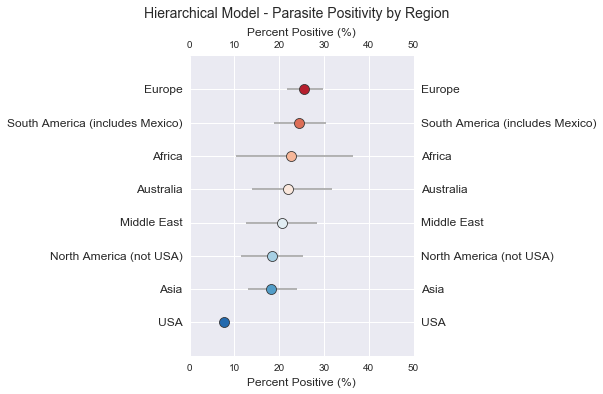

In [74]:
sns.set_context("notebook")
sns.set_style("darkgrid")
g = sns.FacetGrid(hue="mean", data=region_results, palette="RdBu_r", size=5, aspect=.8)
g.map(plt.scatter, 'mean', "order", marker="o", s=100, edgecolor="#333333", linewidth=0.8, zorder=10)
g.map(plt.hlines, 'order', 'hpd_2.5', 'hpd_97.5', color="#aaaaaa")
g.axes.flat[0].set_ylabel("", size=12)
g.axes.flat[0].set_xlabel("Percent Positive (%)", size=12)
g.axes.flat[0].set_ylim([-1, region_results["order"].max() + 1])
g.axes.flat[0].set_yticks(np.arange(region_results["order"].max() + 1))
g.axes.flat[0].set_yticklabels(region_results.location, size=12);
plt.gca().tick_params(labelbottom="on", labeltop="on", labelleft="on", labelright="on")
ax1 = plt.gca()
ax1.set_xlim([0,50])
ax2 = ax1.twiny()
ax2.set_zorder(1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("Percent Positive (%)", size=12)
ax1.set_zorder(ax2.get_zorder()+1)
plt.suptitle("Hierarchical Model - Parasite Positivity by Region", y=1.09, x=0.53, size=14);

Again, the data is fundamentally biased because it’s not a random sample, so this isn’t saying that Europe as a whole has more parasites than Africa, just that our patient population from these places do (with the uncertainty in Africa’s estimation the opposite might actually be true). The US estimate is near 8%, which is exactly what you would get if you simply calculated the overall positivity of US samples. I take this as one sign that the model is giving reasonable results.

Finally, plotting the full posterior positivity distribution for each location:

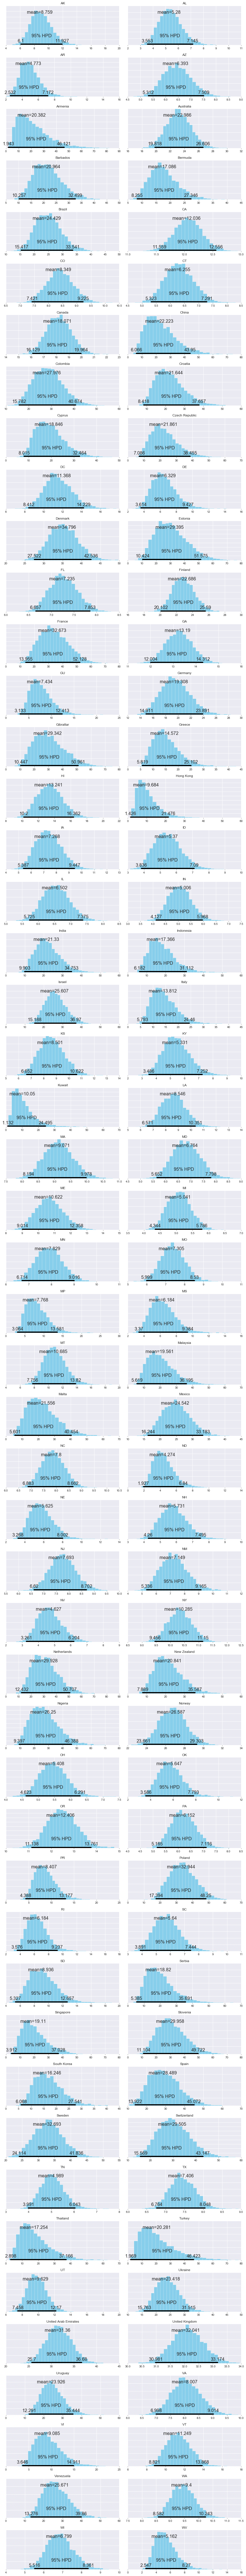

In [85]:
plot_post(trace, is_hier=True, color="#87ceeb", transform=lambda x: x*100);

In [86]:
#Posterior plotting code from PYMC3, hacked here to plot multilevel trace. 
from scipy.stats import kde, mode
from pymc3.stats import autocorr, quantiles, hpd
from numpy.linalg import LinAlgError

label_vars = [location_le.inverse_transform(i) for i in range(trace.get_values("location_mean").shape[1]-1)]
label_name = "location_mean"

def plot_post(trace, varnames=None, transform=lambda x: x, figsize=None, is_hier=False, hier_val=label_name,\
              alpha_level=0.05, round_to=3, point_estimate='mean', rope=None,\
              ref_val=None, kde_plot=False, plot_transformed=False, ax=None, **kwargs):

    def plot_posterior_op(trace_values, ax):

        def format_as_percent(x, round_to=0):
            value = np.round(100 * x, round_to)
            if round_to == 0:
                value = int(value)
            return '{}%'.format(value)

        def display_ref_val(ref_val):
            less_than_ref_probability = (trace_values < ref_val).mean()
            greater_than_ref_probability = (trace_values >= ref_val).mean()
            ref_in_posterior = format_as_percent(less_than_ref_probability, 1) + ' <{:g}< '.format(ref_val) + format_as_percent(
                greater_than_ref_probability, 1)
            ax.axvline(ref_val, ymin=0.02, ymax=.75, color='g',
            linewidth=4, alpha=0.65)
            ax.text(trace_values.mean(), plot_height * 0.6, ref_in_posterior,
                        size=14, horizontalalignment='center')

        def display_rope(rope):
            pc_in_rope = format_as_percent(np.sum((trace_values > rope[0]) &
            (trace_values < rope[1]))/len(trace_values), round_to)
            ax.plot(rope, (plot_height * 0.02, plot_height * 0.02),
            linewidth=20, color='r', alpha=0.75)
            text_props = dict(size=16, horizontalalignment='center', color='r')
            ax.text(rope[0], plot_height * 0.14, rope[0], **text_props)
            ax.text(rope[1], plot_height * 0.14, rope[1], **text_props)

        def display_point_estimate():
            if not point_estimate:
                return
            if point_estimate not in ('mode', 'mean', 'median'):
                raise ValueError("Point Estimate should be in ('mode','mean','median', None)")
            if point_estimate == 'mean':
                point_value = trace_values.mean()
                point_text = '{}={}'.format(point_estimate, point_value.round(round_to))
            elif point_estimate == 'mode':
                point_value = mode(trace_values.round(round_to))[0][0]
                point_text = '{}={}'.format(point_estimate, point_value.round(round_to))
            elif point_estimate == 'median':
                point_value = np.median(trace_values)
                point_text = '{}={}'.format(point_estimate, point_value.round(round_to))

            ax.text(point_value, plot_height * 0.8, point_text,
                    size=16, horizontalalignment='center')

        def display_hpd():
            hpd_intervals = hpd(trace_values, alpha=alpha_level)
            ax.plot(hpd_intervals, (plot_height * 0.02, plot_height * 0.02), linewidth=4, color='k')
            text_props = dict(size=16, horizontalalignment='center')
            ax.text(hpd_intervals[0], plot_height * 0.07, hpd_intervals[0].round(round_to), **text_props)
            ax.text(hpd_intervals[1], plot_height * 0.07, hpd_intervals[1].round(round_to), **text_props)
            ax.text((hpd_intervals[0] + hpd_intervals[1]) / 2, plot_height * 0.2,
                    format_as_percent(1 - alpha_level) + ' HPD', **text_props)
            
        def format_axes():
            ax.yaxis.set_ticklabels([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.yaxis.set_ticks_position('none')
            ax.xaxis.set_ticks_position('bottom')
            ax.tick_params(axis='x', direction='out', width=1, length=3,
                           color='0.5')
            ax.spines['bottom'].set_color('0.5')

        def set_key_if_doesnt_exist(d, key, value):
            if key not in d:
                d[key] = value
            
        if kde_plot:
            density = kde.gaussian_kde(trace_values)
            l = np.min(trace_values)
            u = np.max(trace_values)
            x = np.linspace(0, 1, 100) * (u - l) + l
            ax.plot(x, density(x), **kwargs)
        else:
            set_key_if_doesnt_exist(kwargs, 'bins', 30)
            set_key_if_doesnt_exist(kwargs, 'edgecolor', 'w')
            set_key_if_doesnt_exist(kwargs, 'align', 'right')
            ax.hist(trace_values, **kwargs)

        plot_height = ax.get_ylim()[1]

        format_axes()
        display_hpd()
        display_point_estimate()
        if ref_val is not None:
            display_ref_val(ref_val)
        if rope is not None:
            display_rope(rope)

    def create_axes_grid(figsize, varnames):
        n = np.ceil(len(varnames) / 2.0).astype(int)
        if figsize is None:
            figsize = (12, n * 2.5)
        fig, ax = plt.subplots(n, 2, figsize=figsize)
        ax = ax.reshape(2 * n)
        if len(varnames) % 2 == 1:
            ax[-1].set_axis_off()
            ax = ax[:-1]
        return ax, fig

    if isinstance(trace, np.ndarray):
        if figsize is None:
            figsize = (6, 2)
        if ax is None:
            fig, ax = plt.subplots()
        plot_posterior_op(transform(trace), ax)
    else:
        if is_hier:
            varnames = label_vars
        else:
            if varnames is None:
                varnames = [name for name in trace.varnames if not name.endswith('_')]

        if ax is None:
            ax, fig = create_axes_grid(figsize, varnames)

        if is_hier:
            for a, v in zip(ax, varnames):
                tr_values = transform(trace.get_values(hier_val, combine=True, squeeze=True)[:,location_le.transform(v)])
                plot_posterior_op(tr_values, ax=a)
                a.set_title(v)
        else:
            for a, v in zip(ax, varnames):
                tr_values = transform(trace.get_values(v, combine=True, squeeze=True))
                plot_posterior_op(tr_values, ax=a)
                a.set_title(v)

        fig.tight_layout()
    return ax